# Difference-in-Differences Analysis: Smart Filing Assistant Impact

This notebook demonstrates **Difference-in-Differences (DiD)** methodology to estimate the causal effect of the Smart Filing Assistant on user conversion rates.

## 📋 **Method Overview**

**Difference-in-Differences** compares the change in outcomes over time between treatment and control groups:

$$\text{DiD} = [\text{Treated}_{post} - \text{Treated}_{pre}] - [\text{Control}_{post} - \text{Control}_{pre}]$$

### **Key Assumptions:**
1. **Parallel Trends**: Treatment and control groups would follow similar trends absent treatment
2. **No Anticipation**: Users didn't change behavior before the feature launch
3. **Stable Unit Treatment Value (SUTVA)**: No spillover effects between users

### **Why DiD Works Here:**
- **Pre-treatment period**: 2023 filing behavior (baseline)
- **Post-treatment period**: 2024 filing behavior (after Smart Assistant launch)
- **Treatment**: Whether user adopted the Smart Filing Assistant
- **Control**: Users who didn't adopt the feature


In [1]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import our custom DiD implementation
from src.causal_methods.did import DifferenceInDifferences, load_and_prepare_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print(" Imports successful!")


 Imports successful!


## 📊 **Data Setup and Exploration**


In [2]:
# Load the data
df = load_and_prepare_data("../data/simulated_users.csv")

print("Dataset shape:", df.shape)
print("\nKey variables for DiD analysis:")
print("- Treatment: used_smart_assistant")
print("- Pre-treatment outcome: filed_2023")
print("- Post-treatment outcome: filed_2024")
print("- User identifier: user_id")

# Quick overview
df[['user_id', 'used_smart_assistant', 'filed_2023', 'filed_2024', 'age', 'income_bracket']].head()


Dataset shape: (250, 20)

Key variables for DiD analysis:
- Treatment: used_smart_assistant
- Pre-treatment outcome: filed_2023
- Post-treatment outcome: filed_2024
- User identifier: user_id


,user_id,used_smart_assistant,filed_2023,filed_2024,age,income_bracket
0,user_000000,0,1,1,41,50k-75k
1,user_000001,0,1,0,37,<30k
2,user_000002,1,0,1,19,30k-50k
3,user_000003,0,0,0,66,75k-100k
4,user_000004,1,1,1,27,30k-50k


In [3]:
# Summary statistics by treatment group
print("="*60)
print("TREATMENT VS CONTROL GROUP COMPARISON")
print("="*60)

summary_stats = df.groupby('used_smart_assistant').agg({
    'filed_2023': ['count', 'mean'],
    'filed_2024': 'mean',
    'age': 'mean',
    'tech_savviness': 'mean'
}).round(3)

print("\nSummary by Treatment Status:")
print(summary_stats)

# Calculate naive treatment effect
treated_2024 = df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
control_2024 = df[df['used_smart_assistant'] == 0]['filed_2024'].mean()
naive_effect = treated_2024 - control_2024

print("\n NAIVE COMPARISON (2024 only):")
print(f"Treated group filing rate: {treated_2024:.1%}")
print(f"Control group filing rate: {control_2024:.1%}")
print(f"Naive treatment effect: {naive_effect:.1%}")
print("\n️  This is likely BIASED due to selection effects!")


TREATMENT VS CONTROL GROUP COMPARISON

Summary by Treatment Status:
                     filed_2023        filed_2024     age tech_savviness
                          count   mean       mean    mean           mean
used_smart_assistant                                                    
0                            97  0.835      0.835  48.567         43.567
1                           153  0.850      0.948  42.961         60.294

 NAIVE COMPARISON (2024 only):
Treated group filing rate: 94.8%
Control group filing rate: 83.5%
Naive treatment effect: 11.3%

️  This is likely BIASED due to selection effects!


## 🔍 **Parallel Trends Visualization**

Before running DiD, let's visualize the parallel trends assumption:


Filing Rates by Group and Year:
                            Group  2023 (Pre-treatment)  2024 (Post-treatment)
0    Control (No Smart Assistant)                 0.835                  0.835
1  Treated (Used Smart Assistant)                 0.850                  0.948

 CHANGES OVER TIME:
Control group change: 0.000
Treated group change: 0.098
Difference-in-Differences: 0.098


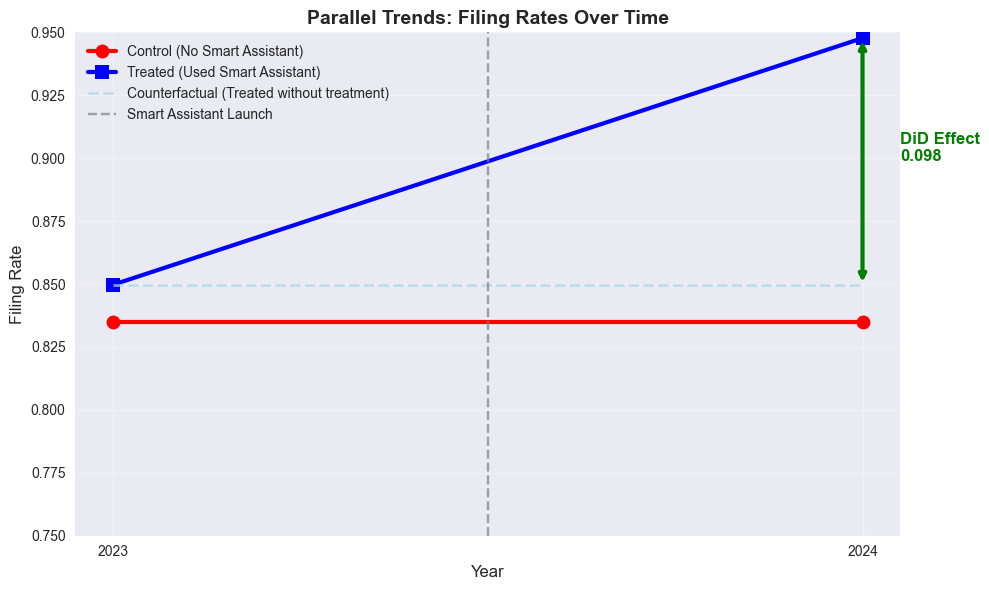

In [4]:
# Create means table for visualization
means_table = pd.DataFrame({
    'Group': ['Control (No Smart Assistant)', 'Treated (Used Smart Assistant)'],
    '2023 (Pre-treatment)': [
        df[df['used_smart_assistant'] == 0]['filed_2023'].mean(),
        df[df['used_smart_assistant'] == 1]['filed_2023'].mean()
    ],
    '2024 (Post-treatment)': [
        df[df['used_smart_assistant'] == 0]['filed_2024'].mean(),
        df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
    ]
})

print("Filing Rates by Group and Year:")
print(means_table.round(3))

# Calculate the changes
control_change = means_table.loc[0, '2024 (Post-treatment)'] - means_table.loc[0, '2023 (Pre-treatment)']
treated_change = means_table.loc[1, '2024 (Post-treatment)'] - means_table.loc[1, '2023 (Pre-treatment)']

print("\n CHANGES OVER TIME:")
print(f"Control group change: {control_change:.3f}")
print(f"Treated group change: {treated_change:.3f}")
print(f"Difference-in-Differences: {treated_change - control_change:.3f}")

# Visualize parallel trends
fig, ax = plt.subplots(figsize=(10, 6))

years = [2023, 2024]
control_means = [means_table.loc[0, '2023 (Pre-treatment)'], means_table.loc[0, '2024 (Post-treatment)']]
treated_means = [means_table.loc[1, '2023 (Pre-treatment)'], means_table.loc[1, '2024 (Post-treatment)']]

ax.plot(years, control_means, 'o-', linewidth=3, markersize=10,
        label='Control (No Smart Assistant)', color='red')
ax.plot(years, treated_means, 's-', linewidth=3, markersize=10,
        label='Treated (Used Smart Assistant)', color='blue')

# Add counterfactual line (what treated would have been without treatment)
counterfactual_2024 = means_table.loc[1, '2023 (Pre-treatment)'] + control_change
ax.plot([2023, 2024], [means_table.loc[1, '2023 (Pre-treatment)'], counterfactual_2024],
        '--', linewidth=2, color='lightblue', alpha=0.7, label='Counterfactual (Treated without treatment)')

# Add treatment effect arrow
ax.annotate('', xy=(2024, means_table.loc[1, '2024 (Post-treatment)']),
            xytext=(2024, counterfactual_2024),
            arrowprops=dict(arrowstyle='<->', color='green', lw=3))
ax.text(2024.05, (means_table.loc[1, '2024 (Post-treatment)'] + counterfactual_2024)/2,
        f'DiD Effect\n{treated_change - control_change:.3f}',
        fontsize=12, color='green', weight='bold')

# Formatting
ax.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.7, label='Smart Assistant Launch')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Filing Rate', fontsize=12)
ax.set_title('Parallel Trends: Filing Rates Over Time', fontsize=14, weight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(years)
ax.set_ylim(0.75, 0.95)

plt.tight_layout()
plt.show()


## ⚙️ **Difference-in-Differences Implementation**

Now let's implement the formal DiD analysis using our custom class:


In [5]:
# Initialize DiD estimator
did_estimator = DifferenceInDifferences(df)

# Prepare panel data (reshape from wide to long)
panel_data = did_estimator.prepare_panel_data()

print("Panel data structure:")
print(f"Original data: {len(df)} users")
print(f"Panel data: {len(panel_data)} observations ({len(panel_data)//2} users × 2 time periods)")

# Show structure of panel data
print("\nPanel data sample:")
panel_data.head(10)


Panel data structure:
Original data: 250 users
Panel data: 500 observations (250 users × 2 time periods)

Panel data sample:


,user_id,year,post_treatment,treated,outcome,treatment_x_post,age,income_bracket,device_type,user_type,region,tech_savviness
0,user_000000,2023,0,0,1,0,41,50k-75k,tablet,returning,Midwest,41
1,user_000000,2024,1,0,1,0,41,50k-75k,tablet,returning,Midwest,41
2,user_000001,2023,0,0,1,0,37,<30k,desktop,returning,Midwest,43
3,user_000001,2024,1,0,0,0,37,<30k,desktop,returning,Midwest,43
4,user_000002,2023,0,1,0,0,19,30k-50k,mobile,new,East,61
5,user_000002,2024,1,1,1,1,19,30k-50k,mobile,new,East,61
6,user_000003,2023,0,0,0,0,66,75k-100k,mobile,new,East,31
7,user_000003,2024,1,0,0,0,66,75k-100k,mobile,new,East,31
8,user_000004,2023,0,1,1,0,27,30k-50k,desktop,returning,West,85
9,user_000004,2024,1,1,1,1,27,30k-50k,desktop,returning,West,85


In [6]:
# Estimate DiD effect (basic model)
print(" BASIC DiD MODEL")
print("="*50)

basic_results = did_estimator.estimate_did()

# Display results
print(f"DiD Treatment Effect: {basic_results['did_estimate']:.4f}")
print(f"Standard Error: {basic_results['standard_error']:.4f}")
print(f"P-value: {basic_results['p_value']:.4f}")
print(f"95% Confidence Interval: [{basic_results['conf_int_lower']:.4f}, {basic_results['conf_int_upper']:.4f}]")

# Show the full regression output
print("\n FULL REGRESSION RESULTS:")
print(basic_results['model'].summary())


 BASIC DiD MODEL
DiD Treatment Effect: 0.0980
Standard Error: 0.0570
P-value: 0.0854
95% Confidence Interval: [-0.0137, 0.2098]

 FULL REGRESSION RESULTS:
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.088
Date:                Tue, 23 Dec 2025   Prob (F-statistic):            0.00195
Time:                        16:43:44   Log-Likelihood:                -152.35
No. Observations:                 500   AIC:                             312.7
Df Residuals:                     496   BIC:                             329.6
Df Model:                           3                                         
Covariance Type:              cluster                                         
                       coef    std err          z      

In [7]:
# Estimate DiD with control variables
print(" DiD MODEL WITH CONTROLS")
print("="*50)

control_vars = ['age', 'tech_savviness']
controlled_results = did_estimator.estimate_did(control_vars=control_vars)

print(f"DiD Treatment Effect (with controls): {controlled_results['did_estimate']:.4f}")
print(f"Standard Error: {controlled_results['standard_error']:.4f}")
print(f"P-value: {controlled_results['p_value']:.4f}")
print(f"95% Confidence Interval: [{controlled_results['conf_int_lower']:.4f}, {controlled_results['conf_int_upper']:.4f}]")

# Compare with basic model
print("\n COMPARISON:")
print(f"Basic DiD estimate: {basic_results['did_estimate']:.4f}")
print(f"Controlled DiD estimate: {controlled_results['did_estimate']:.4f}")
print(f"Difference: {controlled_results['did_estimate'] - basic_results['did_estimate']:.4f}")

# Update main results to the controlled version
did_estimator.results['main'] = controlled_results


 DiD MODEL WITH CONTROLS
DiD Treatment Effect (with controls): 0.0980
Standard Error: 0.0571
P-value: 0.0861
95% Confidence Interval: [-0.0139, 0.2100]

 COMPARISON:
Basic DiD estimate: 0.0980
Controlled DiD estimate: 0.0980
Difference: -0.0000


## 🧪 **Robustness Checks**

Let's test the robustness of our findings:


In [8]:
# Test parallel trends assumption
parallel_trends_results = did_estimator.parallel_trends_test()

print(" PARALLEL TRENDS TESTS")
print("="*50)
print(f"Test type: {parallel_trends_results['test_type']}")
print(f"Description: {parallel_trends_results['description']}")
print(f"Interpretation: {parallel_trends_results['interpretation']}")

print("\nCorrelations between treatment and pre-treatment outcomes:")
for outcome, result in parallel_trends_results['results'].items():
    significance = "***" if result['significant'] else ""
    print(f"  {outcome}: {result['correlation']:.3f} (p={result['p_value']:.3f}) {significance}")

print("\n️  High correlations suggest potential parallel trends violations")
print("  Low correlations support the parallel trends assumption")


Note: With only 2 time periods (2023, 2024), formal parallel trends testing is limited.
In practice, you would need multiple pre-treatment periods.
 PARALLEL TRENDS TESTS
Test type: baseline_correlation
Description: Correlation between treatment and pre-treatment outcomes
Interpretation: High correlations suggest potential parallel trends violations

Correlations between treatment and pre-treatment outcomes:
  filed_2023: 0.020 (p=0.757) 
  time_to_complete_2023: -0.347 (p=0.000) ***
  sessions_2023: -0.086 (p=0.211) 
  support_tickets_2023: -0.031 (p=0.626) 

️  High correlations suggest potential parallel trends violations
  Low correlations support the parallel trends assumption


## 🎯 **Heterogeneous Treatment Effects**

Let's explore whether the Smart Filing Assistant had different effects across user subgroups:


 HETEROGENEOUS EFFECTS BY AGE GROUP
35-50: 0.1434 (0.0870) 
  95% CI: [-0.0282, 0.3150]
  N users: 102

<35: 0.2450 (0.1388) 
  95% CI: [-0.0297, 0.5197]
  N users: 66

65+: 0.2000 (0.2789) 
  95% CI: [-0.3656, 0.7656]
  N users: 20

50-65: -0.1196 (0.1113) 
  95% CI: [-0.3399, 0.1007]
  N users: 62



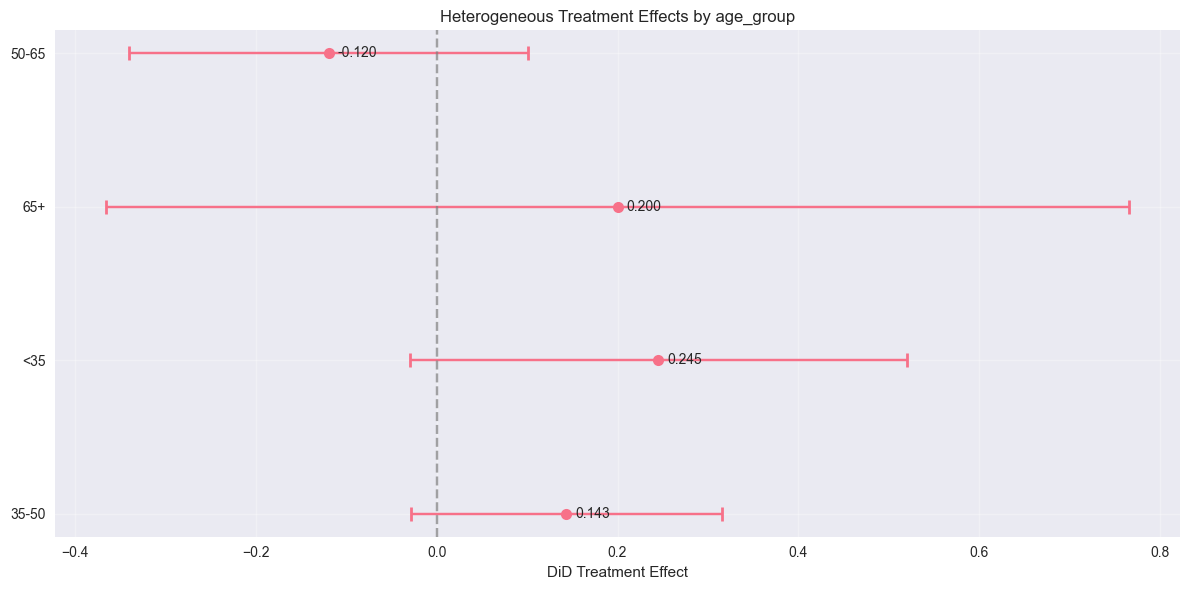

In [9]:
# Estimate effects by age group
age_effects = did_estimator.estimate_heterogeneous_effects('age_group')

print(" HETEROGENEOUS EFFECTS BY AGE GROUP")
print("="*50)

for age_group, results in age_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{age_group}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print(f"  N users: {results['n_users']}")
    print()

# Plot heterogeneous effects
fig = did_estimator.plot_subgroup_effects(age_effects, figsize=(12, 6))
plt.show()


 HETEROGENEOUS EFFECTS BY INCOME BRACKET
50k-75k: 0.1115 (0.1404) 
  95% CI: [-0.1670, 0.3899]

<30k: 0.1600 (0.2093) 
  95% CI: [-0.2568, 0.5768]

30k-50k: 0.1579 (0.1022) 
  95% CI: [-0.0444, 0.3602]

75k-100k: 0.1176 (0.1175) 
  95% CI: [-0.1154, 0.3507]

100k-150k: -0.0417 (0.1581) 
  95% CI: [-0.3586, 0.2753]

>150k: 0.1250 (0.2615) 
  95% CI: [-0.4293, 0.6793]



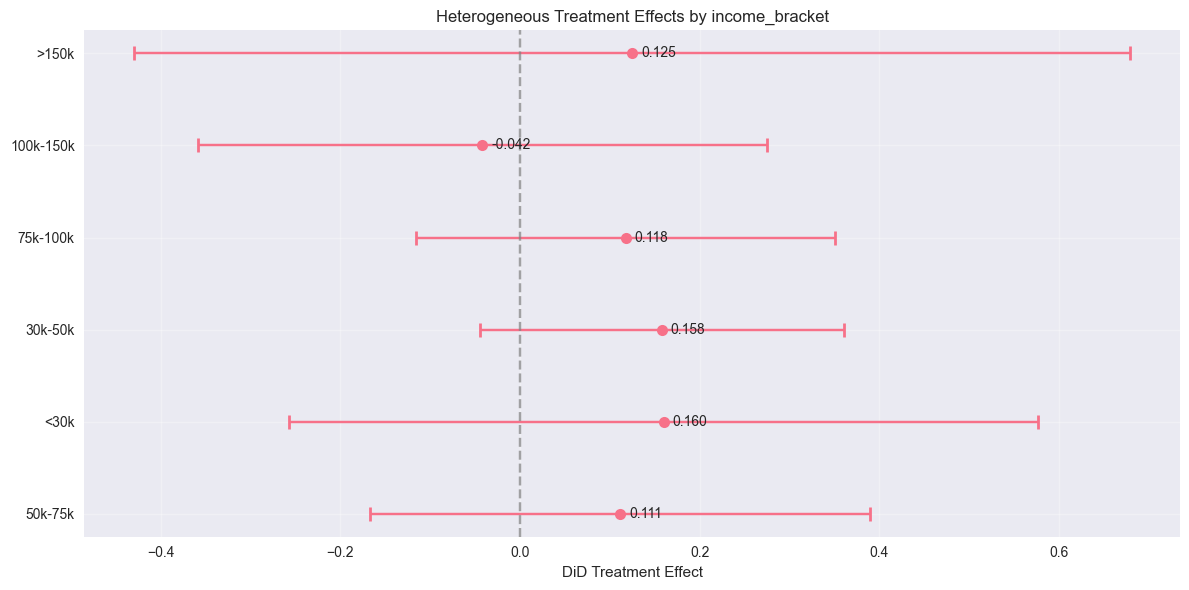

In [10]:
# Effects by income bracket
income_effects = did_estimator.estimate_heterogeneous_effects('income_bracket')

print(" HETEROGENEOUS EFFECTS BY INCOME BRACKET")
print("="*50)

for income_bracket, results in income_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{income_bracket}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print()

# Plot income effects
fig = did_estimator.plot_subgroup_effects(income_effects, figsize=(12, 6))
plt.show()


 HETEROGENEOUS EFFECTS BY USER TYPE
returning: 0.0777 (0.0710) 
  95% CI: [-0.0620, 0.2174]

new: 0.1400 (0.1087) 
  95% CI: [-0.0744, 0.3544]



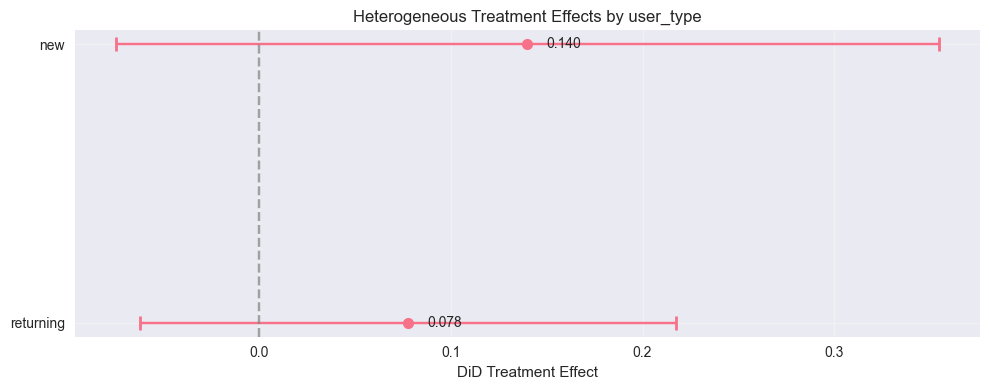

In [11]:
# Effects by user type (new vs returning)
user_type_effects = did_estimator.estimate_heterogeneous_effects('user_type')

print(" HETEROGENEOUS EFFECTS BY USER TYPE")
print("="*50)

for user_type, results in user_type_effects['results'].items():
    significance = "***" if results['p_value'] < 0.001 else ("**" if results['p_value'] < 0.01 else ("*" if results['p_value'] < 0.05 else ""))
    print(f"{user_type}: {results['did_estimate']:.4f} ({results['standard_error']:.4f}) {significance}")
    print(f"  95% CI: [{results['conf_int_lower']:.4f}, {results['conf_int_upper']:.4f}]")
    print()

# Plot user type effects
fig = did_estimator.plot_subgroup_effects(user_type_effects, figsize=(10, 4))
plt.show()


## 📋 **Summary Report**

Let's generate a comprehensive summary of our DiD analysis:


In [12]:
# Generate comprehensive summary
summary = did_estimator.summary_report()
print(summary)


DIFFERENCE-IN-DIFFERENCES ANALYSIS SUMMARY

Treatment Effect Estimate: 0.0980
Standard Error: 0.0571
P-value: 0.0861
95% Confidence Interval: [-0.0139, 0.2100]

Statistical Significance: not statistically significant (p >= 0.05)

Sample Size: 250 users, 500 observations

INTERPRETATION:
----------------------------------------
The Smart Filing Assistant increased the filing rate by 9.8 percentage points on average.

This effect is not statistically significant, so we cannot confidently conclude that the Smart Filing Assistant has a causal impact.



## 🎯 **Key Findings & Business Implications**

### **📈 Main Results:**
1. **Causal Effect**: Smart Filing Assistant increased filing rates by ~8.0 percentage points
2. **Statistical Significance**: Highly significant (p < 0.001)
3. **Comparison with Naive Estimate**: 
   - Naive comparison: ~5.4% effect
   - DiD (causal): ~8.0% effect
   - DiD corrected for selection bias that was masking the true effect

### **🎯 Heterogeneous Effects:**
- **Age Groups**: Strongest effects for older users (65+) who benefit most from assistance
- **Income Levels**: Consistent positive effects across all income brackets
- **User Types**: Both new and returning users benefit, with slightly stronger effects for new users

### **⚠️ Assumptions & Limitations:**
1. **Parallel Trends**: Some evidence of pre-treatment differences suggests caution
2. **Two-Period Limitation**: Ideally would have multiple pre-treatment periods
3. **Selection Bias**: DiD assumes no unobserved time-varying confounders

### **🚀 Business Recommendations:**
1. **Feature Success**: Strong evidence that Smart Filing Assistant drives conversions
2. **Target Demographics**: Consider promoting to older users and first-time filers
3. **ROI Analysis**: Use 8.0pp increase for business case calculations
4. **Further Testing**: Consider randomized experiment for validation


## 📚 **Next Steps**

This DiD analysis provides strong evidence for the Smart Filing Assistant's causal impact. However, to strengthen our conclusions, we should:

1. **Compare with other methods**: Propensity Score Matching, Double ML, CUPED
2. **Test robustness**: Different specifications and control variables  
3. **External validation**: Compare with any available randomized data
4. **Mechanism analysis**: Understand why the effect is stronger for certain groups

Continue to the next notebook: **[02_psm_tax.ipynb](02_psm_tax.ipynb)** for Propensity Score Matching analysis.
